In [10]:
# ==============================================================
# Global Imports
# ==============================================================

import os, cv2, shutil, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
import clip

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    log_loss,
    confusion_matrix
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight

from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2


In [7]:
# ==============================================================
# Color Histogram Baseline
# ==============================================================

dataset_folder = "data/dataset_train/dataset_train"
image_paths = load_image_paths(dataset_folder)

color_features = np.array([extract_color_histogram(p) for p in image_paths])

np.save("color_features.npy", color_features)
np.save("color_image_paths.npy", np.array(image_paths))

print("Saved color histogram features:", len(image_paths))


Saved color histogram features: 14876


In [8]:
# ==============================================================
# Merge Style Folders
# ==============================================================

merge_map = {
    "modern": "modern_contemporary",
    "contemporary": "modern_contemporary",
    "transitional": "modern_contemporary",
    "asian": "modern_contemporary",
    "scandinavian": "modern_contemporary",
    "mid-century-modern": "modern_contemporary",

    "rustic": "rustic_farmhouse",
    "farmhouse": "rustic_farmhouse",
    "craftsman": "rustic_farmhouse",
    "french-country": "rustic_farmhouse",

    "industrial": "industrial",

    "coastal": "coastal_natural",
    "mediterranean": "coastal_natural",

    "traditional": "classic_traditional",
    "victorian": "classic_traditional",
    "shabby-chic-style": "classic_traditional",

    "eclectic": "eclectic_other",
    "southwestern": "eclectic_other",
    "tropical": "eclectic_other"
}

def merge_dataset(src_root, dst_root):
    os.makedirs(dst_root, exist_ok=True)
    counts = defaultdict(int)

    for old_style, new_group in merge_map.items():
        src = os.path.join(src_root, old_style)
        dst = os.path.join(dst_root, new_group)
        os.makedirs(dst, exist_ok=True)

        if not os.path.exists(src):
            print("Skipping missing folder:", src)
            continue

        for fname in os.listdir(src):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                shutil.copy2(os.path.join(src, fname), os.path.join(dst, fname))
                counts[new_group] += 1

    return counts


for split in ["train", "test"]:
    src = f"data/dataset_{split}/dataset_{split}"
    dst = f"data/dataset_{split}_merged"
    result = merge_dataset(src, dst)
    print(f"\nMerged {split} →", result)



Merged train → defaultdict(<class 'int'>, {'modern_contemporary': 4722, 'rustic_farmhouse': 3140, 'industrial': 764, 'coastal_natural': 1583, 'classic_traditional': 2314, 'eclectic_other': 2353})

Merged test → defaultdict(<class 'int'>, {'modern_contemporary': 1183, 'rustic_farmhouse': 788, 'industrial': 192, 'coastal_natural': 397, 'classic_traditional': 580, 'eclectic_other': 589})


In [9]:
# ==============================================================
# Train Style CNN
# ==============================================================

train_dir = "data/dataset_train_merged"
val_dir   = "data/dataset_test_merged"

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
).flow_from_directory(train_dir, target_size=(224,224))

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=(224,224), shuffle=False
)

base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))
for layer in base.layers[:-20]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
out = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(base.input, out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("style_cnn_best.h5", save_best_only=True)
    ]
)

model.save("style_cnn_final.h5")
print("Saved: style_cnn_final.h5")



Found 14876 images belonging to 6 classes.
Found 3729 images belonging to 6 classes.


/Users/sophie/Desktop/new final project/new_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.3470 - loss: 1.6821

465/465 ━━━━━━━━━━━━━━━━━━━━ 158s 329ms/step - accuracy: 0.3471 - loss: 1.6819 - val_accuracy: 0.3288 - val_loss: 2.3140
Epoch 2/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.4596 - loss: 1.3931

465/465 ━━━━━━━━━━━━━━━━━━━━ 161s 345ms/step - accuracy: 0.4596 - loss: 1.3931 - val_accuracy: 0.3757 - val_loss: 2.0705
Epoch 3/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4956 - loss: 1.3161

465/465 ━━━━━━━━━━━━━━━━━━━━ 170s 365ms/step - accuracy: 0.4956 - loss: 1.3161 - val_accuracy: 0.4277 - val_loss: 1.6344
Epoch 4/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5127 - loss: 1.2562

465/465 ━━━━━━━━━━━━━━━━━━━━ 178s 382ms/step - accuracy: 0.5127 - loss: 1.2562 - val_accuracy: 0.4218 - val_loss: 1.6033
Epoch 5/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5437 - loss: 1.1885

465/465 ━━━━━━━━━━━━━━━━━━━━ 184s 395ms/step - accuracy: 0.5437 - loss: 1.1886 - val_accuracy: 0.4318 - val_loss: 1.5729
Epoch 6/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5699 - loss: 1.1318

465/465 ━━━━━━━━━━━━━━━━━━━━ 743s 2s/step - accuracy: 0.5699 - loss: 1.1318 - val_accuracy: 0.4776 - val_loss: 1.4323
Epoch 7/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5807 - loss: 1.0992

465/465 ━━━━━━━━━━━━━━━━━━━━ 157s 338ms/step - accuracy: 0.5807 - loss: 1.0992 - val_accuracy: 0.4932 - val_loss: 1.4236
Epoch 8/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 162s 349ms/step - accuracy: 0.6106 - loss: 1.0341 - val_accuracy: 0.4878 - val_loss: 1.4647
Epoch 9/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 172s 369ms/step - accuracy: 0.6303 - loss: 0.9899 - val_accuracy: 0.4827 - val_loss: 1.4554
Epoch 10/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 2953s 6s/step - accuracy: 0.6514 - loss: 0.9286 - val_accuracy: 0.4798 - val_loss: 1.5046
Epoch 11/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 824s 2s/step - accuracy: 0.6693 - loss: 0.8927 - val_accuracy: 0.4663 - val_loss: 1.6007
Epoch 12/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 155s 332ms/step - accuracy: 0.6921 - loss: 0.8177 - val_accuracy: 0.4259 - val_loss: 1.9180


Saved: style_cnn_final.h5


In [10]:
# ==============================================================
# CLIP Room-Type Labeling
# ==============================================================

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)

room_types = [
    "a photo of a kitchen",
    "a photo of a bedroom",
    "a photo of a bathroom",
    "a photo of a living room",
    "a photo of a dining room",
    "a photo of a home office"
]

text_tokens = clip.tokenize(room_types).to(device)

all_paths = load_image_paths("data/dataset_train/dataset_train")
labels = []

for path in tqdm(all_paths, desc="Labeling rooms"):
    try:
        img = preprocess_clip(Image.open(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            img_feat = clip_model.encode_image(img)
            txt_feat = clip_model.encode_text(text_tokens)
            probs = (img_feat @ txt_feat.T).softmax(dim=-1)
            idx = probs.argmax().item()
            room = room_types[idx].replace("a photo of a ", "")
    except:
        room = "unknown"

    labels.append((path, room))

df = pd.DataFrame(labels, columns=["image_path", "room_type"])
df.to_csv("roomtype_labels.csv", index=False)
print("Saved roomtype_labels.csv")


Labeling rooms: 100%|██████████| 14876/14876 [53:22<00:00,  4.64it/s]    

Saved roomtype_labels.csv


In [11]:
# ==============================================================
# Precompute Embeddings for Search
# ==============================================================

style_model = tf.keras.models.load_model("style_cnn_best.h5")
style_embedding_model = Model(
    inputs=style_model.input,
    outputs=style_model.layers[-2].output
)

# Load Places365 model
model_file = "resnet50_places365.pth.tar"
if not os.path.exists(model_file):
    torch.hub.download_url_to_file(
        "http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar",
        model_file
    )

room_model = models.resnet50(num_classes=365)
checkpoint = torch.load(model_file, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
room_model.load_state_dict(state_dict)
room_model.eval()

# Load labels
if not os.path.exists("categories_places365.txt"):
    torch.hub.download_url_to_file(
        "https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt",
        "categories_places365.txt"
    )

with open("categories_places365.txt") as f:
    classes = [line.strip().split(" ")[0][3:] for line in f]

room_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


def predict_room_label(path):
    img = Image.open(path).convert("RGB")
    x = room_tf(img).unsqueeze(0)
    with torch.no_grad():
        logits = room_model(x)
        idx = torch.nn.functional.softmax(logits, dim=1).argmax().item()
    return idx, classes[idx]


def get_style_embedding(path):
    img = preprocess_tf(path)
    return style_embedding_model.predict(img, verbose=0).flatten()


# Run
dataset_folder = "data/dataset_train/dataset_train"
image_paths = load_image_paths(dataset_folder)

style_embeddings = []
room_labels = []

for p in tqdm(image_paths, desc="Embedding"):
    style_embeddings.append(get_style_embedding(p))
    room_labels.append(predict_room_label(p)[0])

np.save("style_embeddings.npy", np.array(style_embeddings))
np.save("room_labels.npy", np.array(room_labels))
np.save("image_paths.npy", np.array(image_paths))

print("Saved all embeddings!")


Embedding: 100%|██████████| 14876/14876 [18:26<00:00, 13.45it/s]

Saved all embeddings!



=== Query: blog_figures/validation_set_bedroom.jpg ===

Predicted room type: bedroom


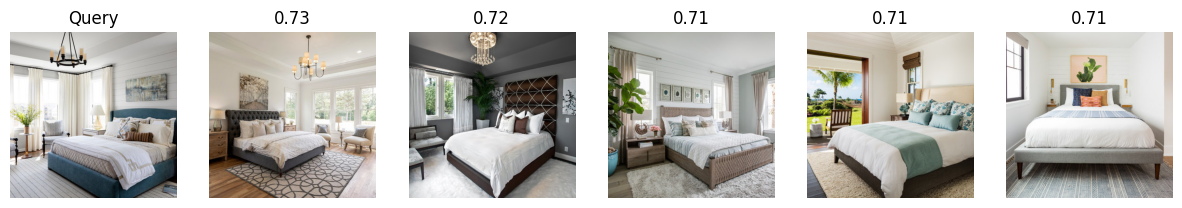


=== Query: blog_figures/validation_set_bathroom.jpg ===

Predicted room type: bathroom


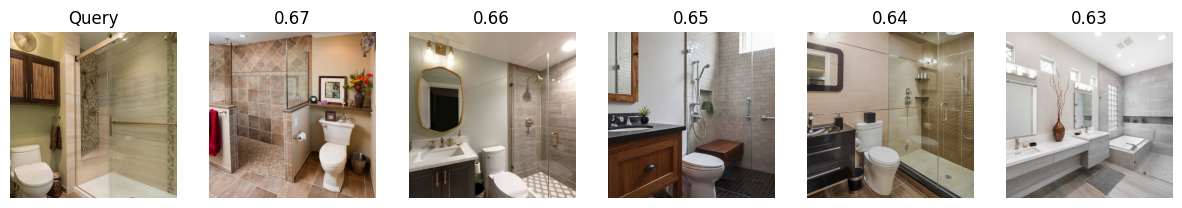


=== Query: blog_figures/my_bathroom.jpg ===

Predicted room type: bathroom


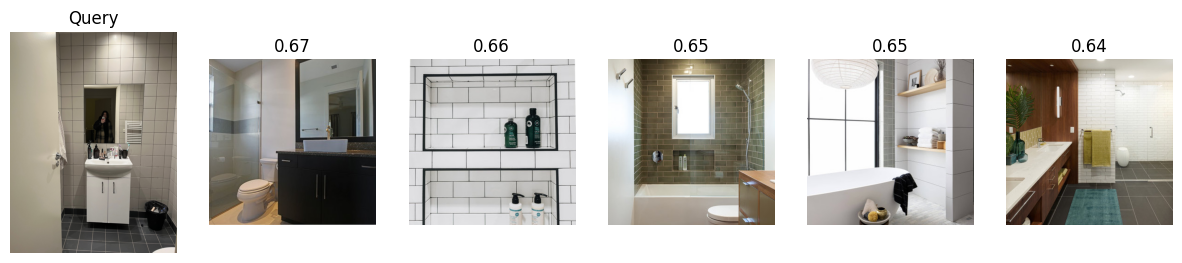


=== Query: blog_figures/my_bedroom.jpg ===

Predicted room type: dorm_room


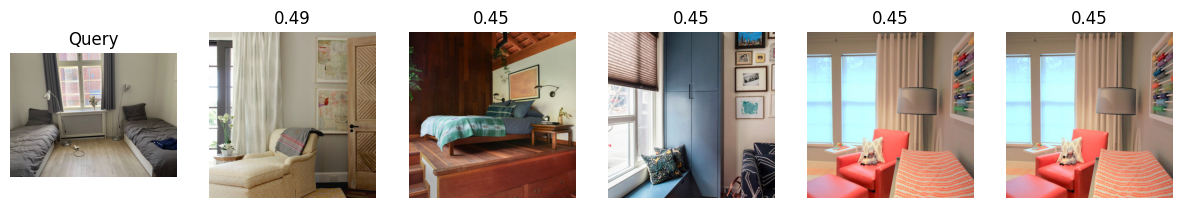

In [12]:
# ==============================================================
# Style Similarity Search
# ==============================================================

style_embeddings = np.load("style_embeddings.npy")
room_labels = np.load("room_labels.npy")
image_paths = np.load("image_paths.npy", allow_pickle=True)

def find_similar_images(query_path, top_k=5):
    q_room, room_name = predict_room_label(query_path)
    print("\nPredicted room type:", room_name)

    valid = np.where(room_labels == q_room)[0]
    if len(valid) == 0:
        print("No same-room images found.")
        return []

    q_emb = get_style_embedding(query_path)
    sims = cosine_similarity([q_emb], style_embeddings[valid])[0]

    idxs = np.argsort(sims)[::-1][:top_k]
    return [(image_paths[valid[i]], sims[i]) for i in idxs]


def show_results(query_path, results):
    plt.figure(figsize=(15,4))
    plt.subplot(1, len(results)+1, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(query_path), cv2.COLOR_BGR2RGB))
    plt.title("Query")
    plt.axis("off")

    for i, (img_path, score) in enumerate(results, 2):
        plt.subplot(1, len(results)+1, i)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"{score:.2f}")
        plt.axis("off")

    plt.show()


# ===== Queries =====

queries = [
    "blog_figures/validation_set_bedroom.jpg",
    "blog_figures/validation_set_bathroom.jpg",
    "blog_figures/my_bathroom.jpg",
    "blog_figures/my_bedroom.jpg"
]

for q in queries:
    print("\n=== Query:", q, "===")
    results = find_similar_images(q, top_k=5)
    show_results(q, results)



=== Histogram Query: blog_figures/validation_set_bedroom.jpg ===


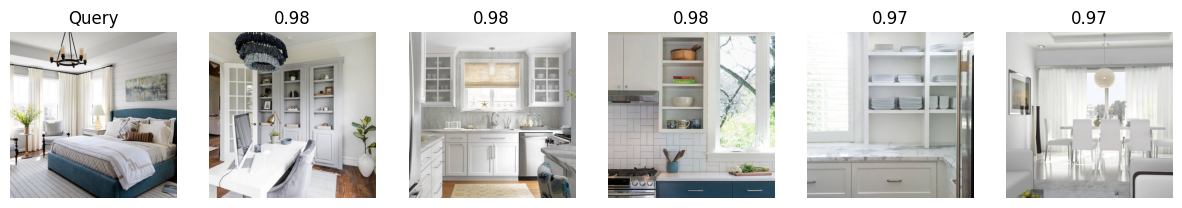


=== Histogram Query: blog_figures/validation_set_bathroom.jpg ===


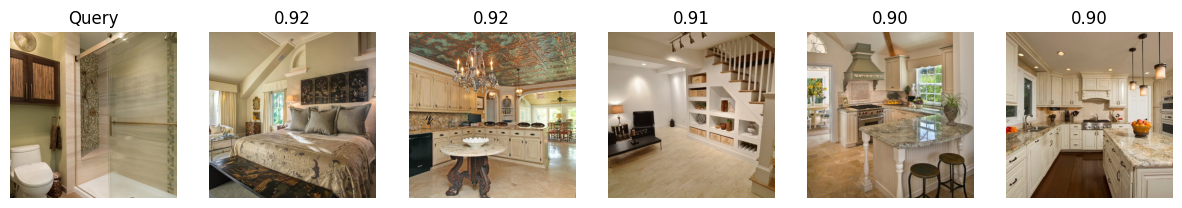


=== Histogram Query: blog_figures/my_bathroom.jpg ===


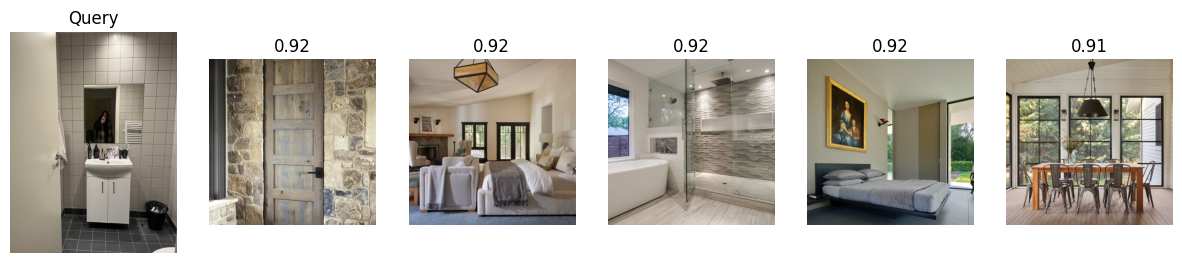


=== Histogram Query: blog_figures/my_bedroom.jpg ===


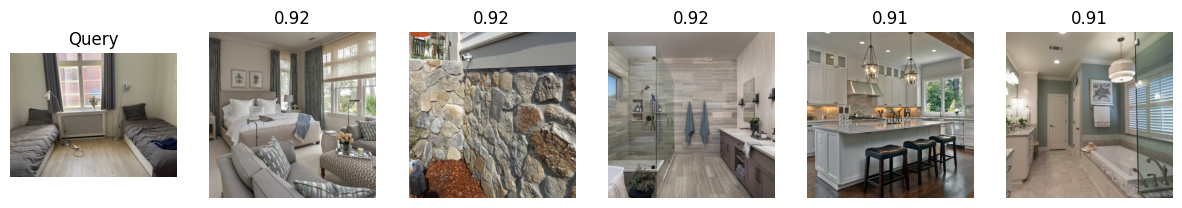

In [13]:
# ==============================================================
# Color Histogram Similarity Search
# ==============================================================

color_features = np.load("color_features.npy")
color_image_paths = np.load("color_image_paths.npy", allow_pickle=True)

def hist_find_similar(query_path, top_k=5):
    q = extract_color_histogram(query_path)
    sims = cosine_similarity([q], color_features)[0]
    idxs = np.argsort(sims)[::-1][:top_k]
    return [(color_image_paths[i], sims[i]) for i in idxs]

# ===== Queries =====

queries = [
    "blog_figures/validation_set_bedroom.jpg",
    "blog_figures/validation_set_bathroom.jpg",
    "blog_figures/my_bathroom.jpg",
    "blog_figures/my_bedroom.jpg"
]

for q in queries:
    print("\n=== Histogram Query:", q, "===")
    results = hist_find_similar(q, top_k=5)
    show_results(q, results)



Evaluating Room Style CNN (Keras)


Found 3729 images belonging to 6 classes.


/Users/sophie/Desktop/new final project/new_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


117/117 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step

Room Style CNN Accuracy: 49.32%
Room Style CNN Loss: 1.4236
                     precision    recall  f1-score  support
classic_traditional   0.507042  0.310345  0.385027    580.0
coastal_natural       0.411765  0.088161  0.145228    397.0
eclectic_other        0.519313  0.410866  0.458768    589.0
industrial            0.556701  0.281250  0.373702    192.0
modern_contemporary   0.553698  0.727811  0.628926   1183.0


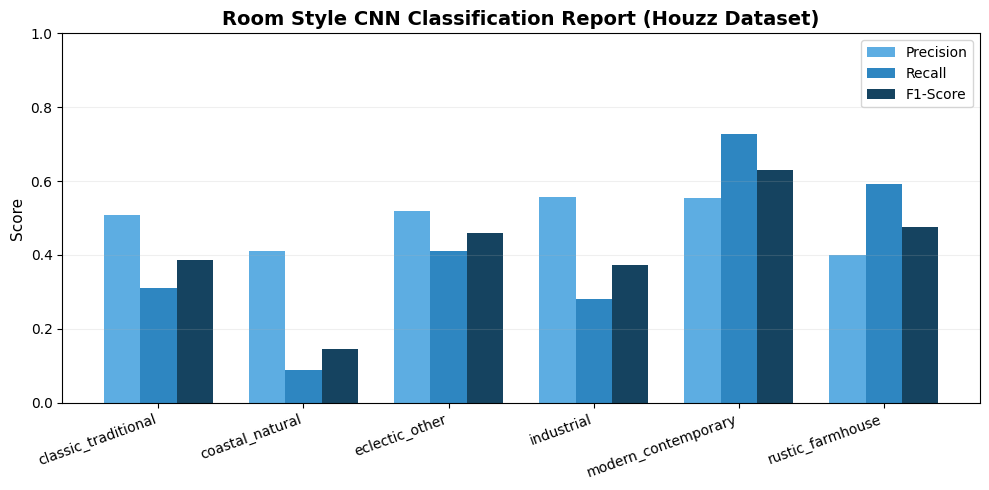


Evaluating Pretrained Room-Type CNN (PyTorch)

Pretrained Room-Type CNN Accuracy: 0.76%
Pretrained Room-Type CNN Loss: 10.2259


/Users/sophie/Desktop/new final project/new_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [14]:
# --------------------------------------------------------------
#  Helper function to plot a classification report
# --------------------------------------------------------------
def plot_classification_report(report_df, title):
    """Display a clean bar chart for precision, recall, and F1."""
    report_df = report_df.iloc[:-3, :]  # drop avg rows

    plt.figure(figsize=(10, 5))
    x = np.arange(len(report_df))
    bar_width = 0.25

    plt.bar(x - bar_width, report_df['precision'], width=bar_width, label='Precision', color='#5DADE2')
    plt.bar(x, report_df['recall'], width=bar_width, label='Recall', color='#2E86C1')
    plt.bar(x + bar_width, report_df['f1-score'], width=bar_width, label='F1-Score', color='#154360')

    plt.xticks(x, report_df.index, rotation=20, ha='right', fontsize=10)
    plt.ylabel("Score", fontsize=11)
    plt.ylim(0, 1)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend()
    plt.grid(axis='y', alpha=0.2)
    plt.tight_layout()
    plt.show()


# ==============================================================
#  Evaluate Room Style CNN
# ==============================================================

print("\n==============================")
print("Evaluating Room Style CNN (Keras)")
print("==============================")

style_model = tf.keras.models.load_model("style_cnn_best.h5")

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "data/dataset_test_merged",
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

y_true_style = val_gen.classes
y_pred_probs_style = style_model.predict(val_gen, verbose=1)
y_pred_style = np.argmax(y_pred_probs_style, axis=1)
class_labels = list(val_gen.class_indices.keys())

# Metrics
style_acc = accuracy_score(y_true_style, y_pred_style)
style_loss = log_loss(y_true_style, y_pred_probs_style)
print(f"\nRoom Style CNN Accuracy: {style_acc*100:.2f}%")
print(f"Room Style CNN Loss: {style_loss:.4f}")

style_report = classification_report(
    y_true_style,
    y_pred_style,
    target_names=class_labels,
    digits=3,
    output_dict=True
)

style_df = pd.DataFrame(style_report).transpose()
print(style_df.head())

plot_classification_report(
    style_df,
    title="Room Style CNN Classification Report (Houzz Dataset)"
)


# ==============================================================
#  Evaluate Pretrained Room-Type CNN (PyTorch)
# ==============================================================

print("\n==============================")
print("Evaluating Pretrained Room-Type CNN (PyTorch)")
print("==============================")

checkpoint = torch.load("resnet50_places365.pth.tar", map_location="cpu")
roomtype_model = models.resnet50(num_classes=365)
state_dict = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}
roomtype_model.load_state_dict(state_dict)
roomtype_model.eval()

data_dir = "data/roomtype_auto_clip_sorted"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
class_names = dataset.classes

y_true_room, y_pred_room, y_probs_room = [], [], []
with torch.no_grad():
    for imgs, labels in loader:
        outputs = roomtype_model(imgs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true_room.extend(labels.numpy())
        y_pred_room.extend(preds.numpy())
        y_probs_room.extend(probs.numpy())


# Metrics
roomtype_acc = accuracy_score(y_true_room, y_pred_room)
# Slice predicted probabilities to match number of true classes
roomtype_loss = log_loss(y_true_room, np.array(y_probs_room)[:, :len(set(y_true_room))])
print(f"\nPretrained Room-Type CNN Accuracy: {roomtype_acc*100:.2f}%")
print(f"Pretrained Room-Type CNN Loss: {roomtype_loss:.4f}")
